<a href="https://colab.research.google.com/github/gabilodeau/INF8770/blob/master/Transformee%20KL%20sur%20image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF8770 Technologies multimédias

Polytechnique Montréal

Exemple de l'application de la transformée KL sur une image

In [1]:
import numpy as np
import matplotlib.pyplot as py
from PIL import Image
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

Paramètres pour la compression

In [2]:
convYUV = True
quant = (8, 4, 4)

Lecture d'une image. Image transformée en double précision pour les calculs 

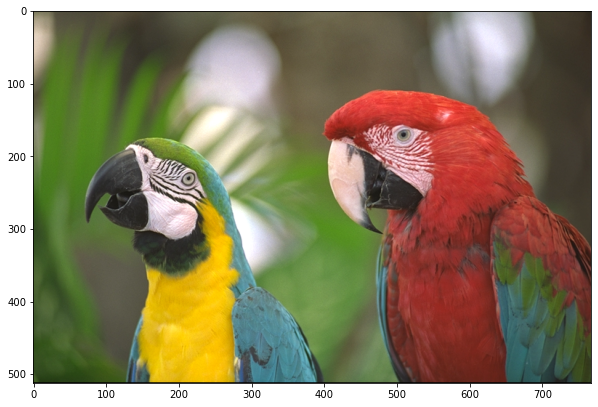

In [3]:
py.figure(figsize = (10,10))
imageLue = np.array(Image.open('data/kodim23.png'))
py.imshow(imageLue)
py.show()
image = imageLue.astype('double')

Conversion vers YUV (si nécessaire)

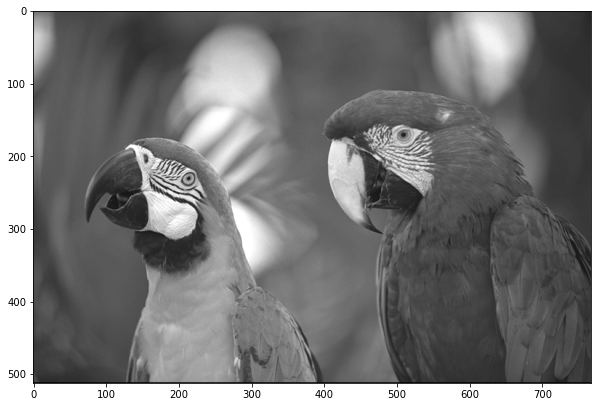

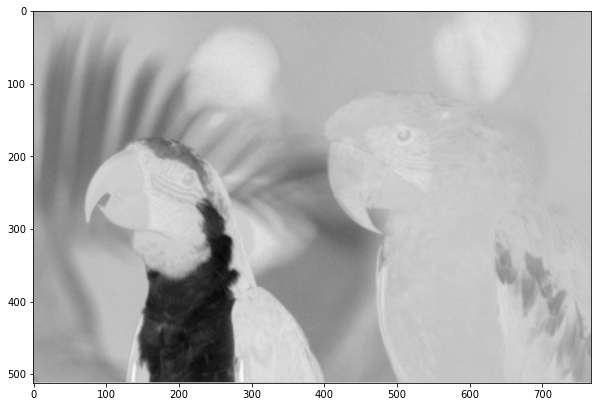

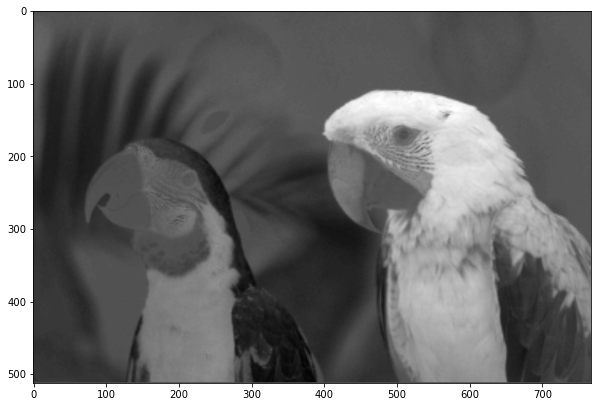

In [4]:
if(convYUV):
    for i in range(len(image)):
        for j in range(len(image[0])):
            Y = (image[i][j][0] + 2 * image[i][j][1] + image[i][j][2]) / 4
            U = image[i][j][2] - image[i][j][1]
            V = image[i][j][0] - image[i][j][1]
            image[i][j] = [Y, U, V]
            
py.figure(figsize = (10,10))
py.imshow(image[:,:,0], cmap='gray')
py.show()
py.figure(figsize = (10,10))
py.imshow(image[:,:,1], cmap='gray')
py.show()
py.figure(figsize = (10,10))
py.imshow(image[:,:,2], cmap='gray')
py.show()

Calcul des valeurs moyennes des RGB. Nécessaire pour calculer la matrice de covariance des RGB

In [5]:
sommeR = 0.0
sommeG = 0.0
sommeB = 0.0
for i in range(len(image)):
    for j in range(len(image[0])):
        sommeR += image[i][j][0]
        sommeG += image[i][j][1]
        sommeB += image[i][j][2]
        
nbPixels = len(image) * len(image[0])        
moyR = sommeR / nbPixels
moyG = sommeG / nbPixels
moyB = sommeB / nbPixels

print(moyR)
print(moyG)
print(moyB)

104.16201273600261
-33.801971435546875
12.066151936848959


Calcul de la matrice de covariance des RGB

In [6]:
covRGB = np.zeros((3,3), dtype = "double")
for i in range(len(image)):
    for j in range(len(image[0])):
        vecTemp=[[image[i][j][0] - moyR], [image[i][j][1]] - moyG, [image[i][j][2] - moyB]]
        vecProdTemp = np.dot(vecTemp, np.transpose(vecTemp))
        covRGB = np.add(covRGB, vecProdTemp)

covRGB /= nbPixels        
print(covRGB)

[[2078.90409201 -258.13560513 -127.15363382]
 [-258.13560513 1964.78473896  344.61118286]
 [-127.15363382  344.61118286 2293.00048131]]


Calcul des vecteurs propres et valeurs propres

In [7]:
eigval, eigvec = LA.eig(covRGB)
print(eigval)
print()
print(eigvec)
eigvec = np.transpose(eigvec)

[2626.02015849 2032.35950938 1678.30964441]

[[-0.42463303  0.80548502 -0.41337715]
 [ 0.54323707 -0.13858227 -0.82806306]
 [ 0.72427914  0.57618472  0.37872272]]


Appliquer la transformée KL

In [8]:
imageKL = np.copy(image)
vecMoy = [[moyR], [moyG], [moyB]]

for i in range(len(imageKL)):
    for j in range(len(imageKL[0])):
        vecTemp = [[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
        imageKL[i][j][:] = np.reshape(np.dot(eigvec, np.subtract(vecTemp, vecMoy)), (3))

Quantification

In [9]:
min0 = np.min(imageKL[:,:,0])
min1 = np.min(imageKL[:,:,1])
min2 = np.min(imageKL[:,:,2])

range0 = np.max(imageKL[:,:,0]) - min0
range1 = np.max(imageKL[:,:,1]) - min1
range2 = np.max(imageKL[:,:,2]) - min2

scaling0 = (range0 / (2**quant[0] - 1)) if quant[0] else 0
scaling1 = (range1 / (2**quant[1] - 1)) if quant[1] else 0
scaling2 = (range2 / (2**quant[2] - 1)) if quant[2] else 0

for i in range(len(imageKL)):
    for j in range(len(imageKL[0])):
        imageKL[i][j][0] = (round((imageKL[i][j][0] - min0) / scaling0)) if quant[0] else 0
        imageKL[i][j][1] = (round((imageKL[i][j][1] - min1) / scaling1)) if quant[1] else 0
        imageKL[i][j][2] = (round((imageKL[i][j][2] - min2) / scaling2)) if quant[2] else 0
        
print(imageKL)
        
for i in range(len(imageKL)):
    for j in range(len(imageKL[0])):
        imageKL[i][j][0] = ((imageKL[i][j][0] * scaling0) + min0) if quant[0] else (min0 + (range0 / 2))
        imageKL[i][j][1] = ((imageKL[i][j][1] * scaling1) + min1) if quant[1] else (min1 + (range1 / 2))
        imageKL[i][j][2] = ((imageKL[i][j][2] * scaling2) + min2) if quant[2] else (min2 + (range2 / 2))
        

[[[112.   7.   6.]
  [112.   7.   6.]
  [110.   7.   6.]
  ...
  [155.   3.   7.]
  [155.   3.   7.]
  [155.   3.   7.]]

 [[113.   7.   6.]
  [113.   7.   6.]
  [113.   7.   6.]
  ...
  [155.   3.   7.]
  [155.   3.   7.]
  [155.   3.   7.]]

 [[110.   7.   6.]
  [110.   7.   6.]
  [110.   7.   6.]
  ...
  [155.   3.   7.]
  [155.   3.   7.]
  [155.   3.   7.]]

 ...

 [[100.   3.   8.]
  [ 99.   3.   8.]
  [ 98.   4.   8.]
  ...
  [118.   3.   7.]
  [124.   3.   7.]
  [127.   2.   7.]]

 [[ 98.   3.   8.]
  [100.   3.   8.]
  [ 99.   3.   8.]
  ...
  [120.   3.   7.]
  [123.   3.   8.]
  [125.   3.   8.]]

 [[172.   0.   7.]
  [172.   0.   7.]
  [172.   0.   7.]
  ...
  [172.   0.   7.]
  [172.   0.   7.]
  [172.   0.   7.]]]


Inverse

In [10]:
invEigvec = LA.pinv(eigvec)
vecMoy = [moyR, moyG, moyB] 
imageInv = np.copy(image)

for i in range(len(imageInv)):
    for j in range(len(imageInv[0])):
        vecTemp = [[imageKL[i][j][0]], [imageKL[i][j][1]], [imageKL[i][j][2]]]
        imageInv[i][j][:] = np.add(np.reshape(np.dot(invEigvec, vecTemp), (3)), vecMoy)


Conversion vers RGB (si nécessaire)

In [11]:
if(convYUV):
    for i in range(len(imageInv)):
        for j in range(len(imageInv[0])):
            G = imageInv[i][j][0] - ((imageInv[i][j][1] + imageInv[i][j][2]) / 4)
            R = imageInv[i][j][2] + G
            B = imageInv[i][j][1] + G
            imageInv[i][j] = [R, G, B]

Qualité et taux de compression

In [12]:
imageInv = np.clip(imageInv, 0, 255)
imageObtenue = imageInv.astype('uint8')

compression = 1 - ((quant[0] + quant[1] + quant[2]) / 24)
psnr = peak_signal_noise_ratio(imageLue, imageObtenue)
ssim = structural_similarity(imageLue, imageObtenue, multichannel=True)

Afficher

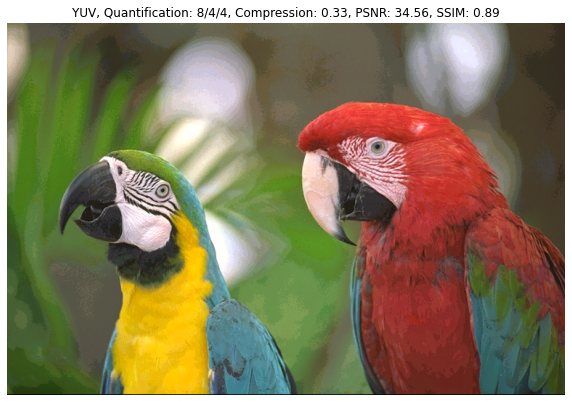

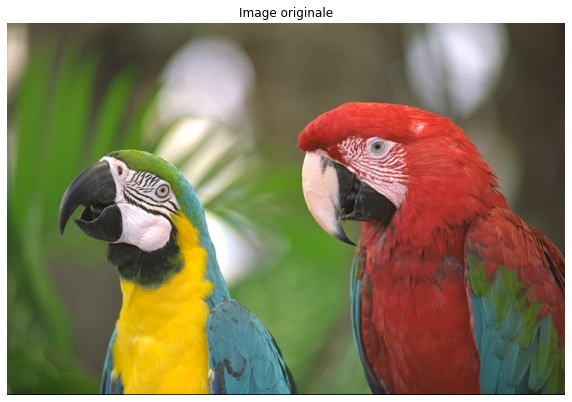

In [13]:
py.figure(figsize = (10,10))
py.imshow(imageObtenue)
title = f"{'YUV' if convYUV else 'RGB'}, Quantification: {quant[0]}/{quant[1]}/{quant[2]}, Compression: {compression:.2f}, PSNR: {psnr:.2f}, SSIM: {ssim:.2f}"
py.title(title)
py.axis('off')
py.show()

py.figure(figsize = (10,10))
py.imshow(imageLue)
py.title('Image originale')
py.axis('off')
py.show()